In [ ]:
import json
import os
import sys
sys.path.append('/home/chengxin/chengxin/vagen')
import torch
import imageio
import torchvision.transforms as transforms
from diffusers.video_processor import VideoProcessor
import torch
from model.wan.pipeline_wan_ttv import AutoencoderKLWan
from diffusers.utils import export_to_video
import numpy as np
from tqdm import tqdm


def read_video(video_path, value_range=(-1, 1), fps=None, size=None, max_frames = None):

    reader = imageio.get_reader(video_path, fps=fps)
    frames = [torch.tensor(frame).to(torch.float32) for frame in reader]
    reader.close()
    video = torch.stack(frames)  # Shape: [T, H, W, C]
    video = video / 255.0
    video = video * (value_range[1] - value_range[0]) + value_range[0]
    
    if size is not None:
        resize_transform = transforms.Resize((size[1], size[0]), antialias=True)
        # Reshape for transform: [T, H, W, C] -> [T, C, H, W]
        video = video.permute(0, 3, 1, 2)
        video = torch.stack([resize_transform(frame) for frame in video])
        # Back to [T, H, W, C]
        video = video.permute(0, 2, 3, 1)
    
    # Ensure number of frames is 4n+1 by trimming excess frames
    num_frames = video.shape[0]
    target_frames = num_frames - (num_frames - 1) % 4  # Closest 4n+1
    if max_frames is not None:    target_frames = min(target_frames, max_frames)
    video = video[:target_frames]  # Trim from the end    
    
    # Permute to [C, T, H, W]
    video = video.permute(3, 0, 1, 2)
    return video



value_range=(-1, 1)
video_size = (832, 480)
video_path = '/home/chengxin/chengxin/vagen/output0.mp4'
model_id = '/home/chengxin/chengxin/vagen/assets/Wan2.1-T2V-1.3B-Diffusers'
device = 'cuda:0'
dtype = torch.float32
vae = AutoencoderKLWan.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype).to(device)
latents_mean = torch.tensor(vae.config.latents_mean).view(1, vae.config.z_dim, 1, 1, 1).to(device, dtype)
latents_std = 1 / torch.tensor(vae.config.latents_std).view(1, vae.config.z_dim, 1, 1, 1).to(device, dtype)
processor = VideoProcessor(vae_scale_factor=vae.config.scale_factor_spatial)




# VAE Encode

In [1]:

import json
import os
import sys
sys.path.append('/home/chengxin/chengxin/vagen')
import torch
import imageio
import torchvision.transforms as transforms
from diffusers.video_processor import VideoProcessor
import torch, torchaudio
from model.wan.pipeline_wan_ttv import AutoencoderKLWan
from diffusers.utils import export_to_video
import numpy as np
from tqdm import tqdm
import shutil
from moviepy import VideoFileClip, AudioFileClip

split = 'train'
save_path= f'/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/{split}/avsync'
latent_save_path = '/home/chengxin/chengxin/Dataset_Sound/VGGSound/latent/wan'
with open(f'/home/chengxin/chengxin/vagen/data/avsync/ks/avsync-{split}-72B-captions.json', 'r', encoding='utf-8') as file:
    data = json.load(file)


final_result = dict()
for name, info in tqdm(data.items()):
    name = name.split('/')[-1]
    dur  = name.split('_')[-3:]
    start_time  = float(dur[-2])
    end_time = float(dur[-1][:-4])
    file_name = name.split('_')[:-3]
    file_name = '_'.join(file_name)
    path1 = f'/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/10/{file_name}.mp4'
    path2 = f'/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/test/10/{file_name}.mp4'
    tensor_path = f'{latent_save_path}/{name}.pt'
    info['video_latent'] = tensor_path
    info['duration'] = end_time - start_time
    if os.path.exists(path1):
        path = path1
    elif os.path.exists(path2):
        path = path2
    else:
        print(file_name, 'not found')
        continue
    

    # 读取视频
    video = VideoFileClip(path)
    subclip = video.subclipped(start_time, end_time)
    video_save_path = f"{save_path}/{name}"
    audio_save_path = video_save_path.replace(".mp4", ".wav")
    subclip.write_videofile(video_save_path, codec="libx264")
    subclip.audio.write_audiofile(audio_save_path)

    final_result[video_save_path] = info
    # with torch.no_grad():
    #     target_video_frames = read_video(path, value_range = value_range, fps = 16, size = video_size, max_frames = 81)
    #     target_latents = vae.encode(target_video_frames.unsqueeze(0).to(device)).latent_dist.mean
    #     target_latents = (target_latents - latents_mean) * latents_std 
    #     torch.save(target_latents.squeeze(0).cpu(), tensor_path)
        
    
    

print(len(final_result), len(data))
with open('/home/chengxin/chengxin/veo3/data/avsync-test-72B-captions.json', 'w', encoding='utf-8') as file:
    json.dump(final_result, file, ensure_ascii=False, indent=4)

/data-87-04/chengxin/envs/veo3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/1350 [00:00<?, ?it/s]

MoviePy - Building video /home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/avsync/077_m7wNT3I_000020_000030_7.0_10.0.mp4.
MoviePy - Writing audio in 077_m7wNT3I_000020_000030_7.0_10.0TEMP_MPY_wvf_snd.mp3


  0%|          | 0/1350 [00:00<?, ?it/s]

MoviePy - Done.
MoviePy - Writing video /home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/avsync/077_m7wNT3I_000020_000030_7.0_10.0.mp4



  0%|          | 0/1350 [00:00<?, ?it/s]


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file /home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/avsync/077_m7wNT3I_000020_000030_7.0_10.0.mp4:

 [out#0/mp4 @ 0x8499280] Error opening output /home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/avsync/077_m7wNT3I_000020_000030_7.0_10.0.mp4: No such file or directory
Error opening output file /home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/avsync/077_m7wNT3I_000020_000030_7.0_10.0.mp4.
Error opening output files: No such file or directory


In [5]:
with torch.no_grad():
    target_latents = torch.load(tensor_path).unsqueeze(0).to(device)
    target_latents = target_latents / latents_std + latents_mean
    video = vae.decode(target_latents, return_dict=False)[0]
    video = processor.postprocess_video(video, output_type='np')

    for i in range(len(video)):
        export_to_video(video[i], f"output{i}.mp4", fps=16)

# VAE Decode

In [ ]:
import sys
sys.path.append('/home/chengxin/chengxin/veo3')
from dataset.hy_video_audio import VideoDataset
from torch.utils.data import Dataset, DataLoader


dataset = VideoDataset(
    json_path="/home/chengxin/chengxin/veo3/data/avsync-test-72B-captions.json",
    load_mode='latent',
)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

for batch in dataloader:
    with torch.no_grad():
        video_latent = batch['video_latent']  # [B, C, T, H, W]

        video_latent = video_latent / latents_std + latents_mean
        video = vae.decode(video_latent, return_dict=False)[0]
        video = processor.postprocess_video(video, output_type='np')
        for i in range(len(video)):
            export_to_video(video[i], f"output{i}.mp4", fps=16)
    break

In [ ]:
for batch in dataloader:
    with torch.no_grad():
        prompt = batch['prompt']  # [B, C, T, H, W]

        video_latent = video_latent / latents_std + latents_mean
        video = vae.decode(video_latent, return_dict=False)[0]
        video = processor.postprocess_video(video, output_type='np')
        for i in range(len(video)):
            export_to_video(video[i], f"output{i}.mp4", fps=16)
    break

# Audio

## 1 Wan-VAE

torch.Size([3, 1, 64, 512])
torch.Size([1, 16, 1, 8, 64])
torch.Size([3, 1, 512, 64])


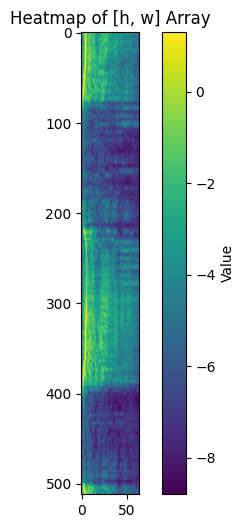

In [36]:
import sys
sys.path.append('/home/chengxin/chengxin/vagen')
import torch, torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from model.wan.pipeline_wan_ttv import AutoencoderKLWan
from transformers import SpeechT5HifiGan
from utils.audiomel import extract_batch_mel


model_id = '/home/chengxin/chengxin/vagen/assets/Wan2.1-T2V-1.3B-Diffusers'
device = 'cuda:0'
dtype = torch.float32
vae = AutoencoderKLWan.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype).to(device)
vocoder = SpeechT5HifiGan.from_pretrained(
    # From pretrained
    "/data-04/xihua/data/ckpt/audioldm2/huggingface/vocoder",
    local_files_only=True,
    low_cpu_mem_usage=True, 
    ignore_mismatched_sizes=False,
    use_safetensors=True,
)


with torch.no_grad():
    va_path = "/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/10/Gwlez841U_I_000007.mp4"
    audio_waveform, audio_sr = torchaudio.load(va_path) 
    if audio_sr != 16000:
        resampler = T.Resample(orig_freq=audio_sr, new_freq=16000)
        audio_waveform = resampler(audio_waveform)
    audio_waveform = audio_waveform[0]  # [channel_num, sample_num] -> [sample_num]
    audio_waveform = torch.stack([audio_waveform])
    audio_waveform, log_mel_spec = extract_batch_mel(audio_waveform, 
                                                    cut_audio_duration = 5.12, 
                                                    sampling_rate = 16000, 
                                                    hop_length = 160, 
                                                    maximum_amplitude = 0.5,
                                                    filter_length = 1024, 
                                                    n_mel = 64, 
                                                    mel_fmin = 0, 
                                                    mel_fmax = 8000, 
                                                    win_length = 1024)

    log_mel_spec_vae = log_mel_spec  # [bs, 1, target_mel_length (sr*duration/hop_length, 1000), n_mel (64)]
    mel_mean = -10
    mel_scale = 20
    log_mel_spec_vae = (log_mel_spec_vae - mel_mean) / mel_scale
    log_mel_spec_vae = torch.concat([log_mel_spec_vae for _ in range(3)]).to(device)
    log_mel_spec_vae = log_mel_spec_vae.unsqueeze(1)
    log_mel_spec_vae = log_mel_spec_vae.transpose(-2, -1).flip(dims=[-2])
    print(log_mel_spec_vae.shape)

    

    audio_latents = vae.encode(log_mel_spec_vae.unsqueeze(0).to(device)).latent_dist.mean    
    print(audio_latents.shape)
    # audio_latents = audio_latents.transpose(-2, -1)

    audio_mel = vae.decode(audio_latents, return_dict=False)[0][0]
    audio_mel = audio_mel * mel_scale + mel_mean
    audio_mel = audio_mel.flip(dims=[-2]).transpose(-2, -1)
    print(audio_mel.shape)

    plt.figure(figsize=(6, 6))  # 设置图形大小（单位：英寸）
    plt.imshow(log_mel_spec[0].cpu().detach(), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Heatmap of [h, w] Array')
    plt.show()


    gen_audio = vocoder(audio_mel.squeeze(1).to(vocoder.device))                               # [bs, duration*sr+...]
    save_path = f"test.wav"
    for i in range(len(gen_audio)):
        torchaudio.save(save_path, gen_audio[i:i+1].cpu(), sample_rate=16000)

## 2. AudioLDM-VAE

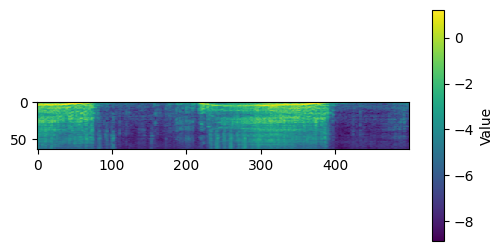

In [23]:

import torch, torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from diffusers.models import AutoencoderKL
from transformers import SpeechT5HifiGan
from utils.audiomel import extract_batch_mel



load_dtype = torch.float32
vae = AutoencoderKL.from_pretrained(
    # From pretrained
    '/data-04/xihua/data/ckpt/audioldm2/huggingface', subfolder="vae", 
    scaling_factor=1.0,
    torch_dtype=load_dtype,
    local_files_only=True,
    low_cpu_mem_usage=False, 
    ignore_mismatched_sizes=False,
    use_safetensors=True,
)
vocoder = SpeechT5HifiGan.from_pretrained(
    # From pretrained
    '/data-04/xihua/data/ckpt/audioldm2/huggingface', subfolder="vocoder", 
    torch_dtype=load_dtype,
    local_files_only=True,
    low_cpu_mem_usage=True, 
    ignore_mismatched_sizes=False,
    use_safetensors=True,
)




with torch.no_grad():
    va_path = "/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/10/Gwlez841U_I_000007.mp4"
    audio_waveform, audio_sr = torchaudio.load(va_path) 
    if audio_sr != 16000:
        resampler = T.Resample(orig_freq=audio_sr, new_freq=16000)
        audio_waveform = resampler(audio_waveform)
    audio_waveform = audio_waveform[0:1]  # [channel_num, sample_num] -> [1, sample_num]
    audio_waveform, log_mel_spec = extract_batch_mel(audio_waveform, 
                                                    cut_audio_duration = 5.00, 
                                                    sampling_rate = 16000, 
                                                    hop_length = 160, 
                                                    maximum_amplitude = 0.5,
                                                    filter_length = 1024, 
                                                    n_mel = 64, 
                                                    mel_fmin = 0, 
                                                    mel_fmax = 8000, 
                                                    win_length = 1024)
    log_mel_spec = log_mel_spec.unsqueeze(1)  # [bs, 1, target_mel_length (sr*duration/hop_length, 1000), n_mel (64)]

    audio_latent = vae.encode(log_mel_spec.to(vae.encoder.conv_in.weight.dtype)).latent_dist    #  [bs, 8, target_mel_length/4(250), n_mel/4(16)]
    audio_latent = audio_latent.sample()                                                        #  [bs, 8, target_mel_length/4(250), n_mel/4(16)]
    # audio_latent = audio_latent.transpose(-2,-1).transpose(-2,-3)                               #  [bs, n_mel/4(16), 8, target_mel_length/4(250)]
    # audio_latent = audio_latent.reshape([audio_latent.shape[0], -1, audio_latent.shape[-1]])    #  [bs, original_channel(16*8), target_mel_length/4(250)]
        

    
    mel_spectrogram = vae.decode(audio_latent).sample                             # [bs, 1, target_mel_length(latent_length*4), 64(16*4)]
    gen_audio = vocoder(mel_spectrogram.squeeze(1))                               # [bs, duration*sr+...]


    plt.figure(figsize=(6, 3))  # 设置图形大小（单位：英寸）
    plt.imshow(mel_spectrogram[0,0].T.cpu().detach(), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.show()

    for i in range(len(gen_audio)):
        torchaudio.save(f"test{i}.wav", gen_audio[i:i+1].cpu(), sample_rate=16000)

# Video Audio Latent Processing

In [2]:
import json, os
import imageio
from tqdm import tqdm
import sys
sys.path.append('/home/chengxin/chengxin/vagen')
import torch, torchaudio
import matplotlib.pyplot as plt
import numpy as np
from model.wan.pipeline_wan_ttv import AutoencoderKLWan
from transformers import SpeechT5HifiGan
from utils.audiomel import extract_batch_mel
import torchvision.transforms as transforms
import torchaudio.transforms as T
from diffusers.video_processor import VideoProcessor
from diffusers.utils import export_to_video
import torch.nn.functional as F


def read_video(video_path, value_range=(-1, 1), fps=None, size=None, max_frames = None):

    reader = imageio.get_reader(video_path, fps=fps)
    frames = [torch.tensor(frame).to(torch.float32) for frame in reader]
    reader.close()
    video = torch.stack(frames)  # Shape: [T, H, W, C]
    video = video / 255.0
    video = video * (value_range[1] - value_range[0]) + value_range[0]
    
    if size is not None:
        resize_transform = transforms.Resize((size[1], size[0]), antialias=True)
        # Reshape for transform: [T, H, W, C] -> [T, C, H, W]
        video = video.permute(0, 3, 1, 2)
        video = torch.stack([resize_transform(frame) for frame in video])
        # Back to [T, H, W, C]
        video = video.permute(0, 2, 3, 1)
    
    # Ensure number of frames is 4n+1 by trimming excess frames
    num_frames = video.shape[0]
    target_frames = num_frames - (num_frames - 1) % 4  # Closest 4n+1
    if max_frames is not None:    target_frames = min(target_frames, max_frames)
    video = video[:target_frames]  # Trim from the end    
    
    # Permute to [C, T, H, W]
    video = video.permute(3, 0, 1, 2)
    return video


model_id = '/home/chengxin/chengxin/vagen/assets/Wan2.1-T2V-1.3B-Diffusers'
device = 'cuda:0'
dtype = torch.float32
vae = AutoencoderKLWan.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype).to(device)
value_range=(-1, 1)
video_size = (832, 480)


latents_mean = torch.tensor(vae.config.latents_mean).view(1, vae.config.z_dim, 1, 1, 1).to(device, dtype)
latents_std = 1 / torch.tensor(vae.config.latents_std).view(1, vae.config.z_dim, 1, 1, 1).to(device, dtype)
mel_mean = -10
mel_scale = 20
audio_latent_save_path= '/home/chengxin/chengxin/Dataset_Sound/VGGSound/latent/mel'
video_latent_save_path= '/home/chengxin/chengxin/Dataset_Sound/VGGSound/latent/wan'





/data-87-04/chengxin/envs/veo3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
with open('/home/chengxin/chengxin/vagen/data/ks/avsync_train-72B-captions.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    
final_result = dict()
for name, info in tqdm(data.items()):
    name = name.split('/')[-1]
    name = name.split('_')[:-3]
    name = '_'.join(name)
    path1 = f'/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/10/{name}.mp4'
    path2 = f'/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/test/10/{name}.mp4'
    audio_tensor_path = f'{audio_latent_save_path}/{name}.pt'
    video_tensor_path = f'{video_latent_save_path}/{name}.pt'

    info['audio_latent'] = audio_tensor_path
    info['video_latent'] = video_tensor_path
    if os.path.exists(path1):
        path = path1
    elif os.path.exists(path2):
        path = path2
    else:
        print(name, 'not found')
        continue
    
    final_result[path] = info
    with torch.no_grad():
        audio_waveform, audio_sr = torchaudio.load(path) 
        audio_waveform = audio_waveform[0]  # [channel_num, sample_num] -> [sample_num]
        if audio_sr != 16000:
            resampler = T.Resample(orig_freq=audio_sr, new_freq=16000)
            audio_waveform = resampler(audio_waveform)
        audio_waveform = torch.stack([audio_waveform])
        audio_waveform, log_mel_spec = extract_batch_mel(audio_waveform, 
                                                        cut_audio_duration = 5.12, 
                                                        sampling_rate = 16000, 
                                                        hop_length = 160, 
                                                        maximum_amplitude = 0.5,
                                                        filter_length = 1024, 
                                                        n_mel = 64, 
                                                        mel_fmin = 0, 
                                                        mel_fmax = 8000, 
                                                        win_length = 1024)

        log_mel_spec_vae = log_mel_spec  # [bs, 1, target_mel_length (sr*duration/hop_length, 1000), n_mel (64)]
        log_mel_spec_vae = (log_mel_spec_vae - mel_mean) / mel_scale
        log_mel_spec_vae = torch.concat([log_mel_spec_vae for _ in range(3)]).to(device)
        log_mel_spec_vae = log_mel_spec_vae.unsqueeze(1)
        log_mel_spec_vae = log_mel_spec_vae.transpose(-2, -1).flip(dims=[-2])
        # print(log_mel_spec_vae.shape)

        audio_latents = vae.encode(log_mel_spec_vae.unsqueeze(0).to(device)).latent_dist.mean    
        audio_latents = audio_latents[0]
        print(audio_latents.shape)

        # audio_mel = vae.decode(audio_latents.unsqueeze(0), return_dict=False)[0][0]
        # audio_mel = audio_mel * mel_scale + mel_mean
        # audio_mel = audio_mel.flip(dims=[-2]).transpose(-2, -1)
        # print(audio_mel.shape)



        target_video_frames = read_video(path, value_range = value_range, fps = 16, size = video_size, max_frames = 81)
        target_latents = vae.encode(target_video_frames.unsqueeze(0).to(device)).latent_dist.mean
        target_latents = (target_latents - latents_mean) * latents_std 
        target_latents = target_latents.squeeze(0)
        print(target_latents.shape)

        torch.save(audio_latents.cpu(), audio_tensor_path)
        torch.save(target_latents.cpu(), video_tensor_path)
        
        
    
    

print(len(final_result), len(data))
with open('/home/chengxin/chengxin/vagen/data/avsync/avsync-train-72B-captions.json', 'w', encoding='utf-8') as file:
    json.dump(final_result, file, ensure_ascii=False, indent=4)

## validation

In [10]:

with open('/home/chengxin/chengxin/vagen/data/avsync/avsync-test-72B-captions.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

processor = VideoProcessor(vae_scale_factor=vae.config.scale_factor_spatial)
vocoder = SpeechT5HifiGan.from_pretrained(
    # From pretrained
    "/data-04/xihua/data/ckpt/audioldm2/huggingface/vocoder",
    local_files_only=True,
    low_cpu_mem_usage=True, 
    ignore_mismatched_sizes=False,
    use_safetensors=True,
)

idx = 0
with torch.no_grad():
    for idx_, (key, item) in enumerate(data.items()):
        if idx_ < idx:
            continue
        print(item['audio_caption'])
        print(item['audio_latent'], item['video_latent'])
        audio_latent = torch.load(item['audio_latent']).to(vae.device)
        audio_latent = audio_latent[...,:-1].reshape(16, 21, 8, -1)
        audio_latent = F.pad(audio_latent, (0, 1))
        video_latent = torch.load(item['video_latent']).to(vae.device)
        print(audio_latent.shape, video_latent.shape)
            

        audio_latent = audio_latent[...,:-1].reshape(16, 1, 8, -1)
        print(audio_latent.shape)
        audio_mel = vae.decode(audio_latent.unsqueeze(0), return_dict=False)[0][0]
        audio_mel = audio_mel * mel_scale + mel_mean
        audio_mel = audio_mel.flip(dims=[-2]).transpose(-2, -1)
        audio_mel = audio_mel.squeeze(-3)[:1]
        print(audio_mel.shape)
        gen_audio = vocoder(audio_mel.to(vocoder.device))                               # [bs, duration*sr+...]
        torchaudio.save("test.wav", gen_audio[0:1].cpu(), sample_rate=16000)
            

        video_latent = video_latent / latents_std + latents_mean
        video = vae.decode(video_latent, return_dict=False)[0]
        video = processor.postprocess_video(video, output_type='np')
        export_to_video(video[0], f"test.mp4", fps=16)

        break


A deep, powerful roar reverberates through the air, accompanied by the forceful exhale of a lion's breath, creating a rumbling soundscape that echoes with the raw power and intensity of the savanna.
/home/chengxin/chengxin/Dataset_Sound/VGGSound/latent/mel/Gwlez841U_I_000007.pt /home/chengxin/chengxin/Dataset_Sound/VGGSound/latent/wan/Gwlez841U_I_000007.pt
torch.Size([16, 21, 8, 4]) torch.Size([16, 21, 60, 104])
torch.Size([16, 1, 8, 63])
torch.Size([1, 504, 64])


In [ ]:

import json
import os
import sys
sys.path.append('/home/chengxin/chengxin/vagen')
import torch
import imageio
import torchvision.transforms as transforms
from diffusers.video_processor import VideoProcessor
import torch, torchaudio
from model.wan.pipeline_wan_ttv import AutoencoderKLWan
from diffusers.utils import export_to_video
import numpy as np
from tqdm import tqdm
import shutil
from moviepy import VideoFileClip, AudioFileClip

split = 'test'
save_path= f'/home/chengxin/chengxin/vagen/data/tta/{split}_avsync.json'
with open(f'/home/chengxin/chengxin/vagen/data/avsync/ks/avsync-{split}-72B-captions.json', 'r', encoding='utf-8') as file:
    data = json.load(file)


final_result = dict()
for name, info in tqdm(data.items()):
    name = name.split('/')[-1]
    dur  = name.split('_')[-3:]
    start_time  = float(dur[-2])
    end_time = float(dur[-1][:-4])
    file_name = name.split('_')[:-3]
    file_name = '_'.join(file_name)

    path1 = f'/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/train/10/{file_name}.mp4'
    path2 = f'/home/chengxin/chengxin/Dataset_Sound/VGGSound/dataset/test/10/{file_name}.mp4'
    if os.path.exists(path1): path = path1
    elif os.path.exists(path2): path = path2
    else:
        print(file_name, 'not found')
        continue
    if path in final_result.keys():
        path_= f"{path[:-4]}_.mp4"
        shutil.copy(path, path_)
        path = path_

    info['audio_caption'] = info['label'].replace('_', " ")
    final_result[path] = info
    # with torch.no_grad():
    #     target_video_frames = read_video(path, value_range = value_range, fps = 16, size = video_size, max_frames = 81)
    #     target_latents = vae.encode(target_video_frames.unsqueeze(0).to(device)).latent_dist.mean
    #     target_latents = (target_latents - latents_mean) * latents_std 
    #     torch.save(target_latents.squeeze(0).cpu(), tensor_path)
        
    
    

print(len(final_result), len(data))
with open(save_path, 'w', encoding='utf-8') as file:
    json.dump(final_result, file, ensure_ascii=False, indent=4)

100%|██████████| 150/150 [00:00<00:00, 10756.10it/s]

PnwTlG1aBdU_000086 not found
149 150


: 

: 